In [1]:
import networkx as nx
import sys
sys.path.append("../")
from pomps.contextual_graphs import *
from pomps.policy_scope import *
from pomps.controllers import *
import pyro
import torch
from tqdm.auto import tqdm
import pyro.distributions as dist

from pomps.fcm import *

# from pomis.optimiser import CausalOptimiser, Objective, SCM
from pomis.scm import BoolDomain, SCM, IntegralDomain, RealDomain

In [41]:
def sampler_over():
    U1 = 1
    return {'U1': U1}

fcm = FunctionalCausalModel({Functor(lambda U1: pyro.sample("C1", dist.Uniform(55, 76)), 'C1'),
                            Functor(lambda: pyro.sample("X1", dist.Normal(1, 0.7)), 'X1'),
                             Functor(lambda X1, U1, C1: pyro.sample("Y", dist.Normal(1, 0.7)), 'Y')},
                           sampler_over)
# def model(count):
#     with pyro.plate("samples", count):
#         age = pyro.sample("age", dist.Uniform(55, 76))
#         bmi = pyro.sample("bmi", dist.Normal(27, 0.7))

#         aspirin_p = torch.sigmoid(-8.0 + 0.10 * age + 0.03 * bmi)
#         statin_p = torch.sigmoid(-13.0 + 0.10 * age + 0.20 * bmi)

#         aspirin = pyro.sample("aspirin", dist.Bernoulli(aspirin_p))
#         statin = pyro.sample("statin", dist.Bernoulli(statin_p))

#         cancer_p = torch.sigmoid(2.2 - 0.05 * age + 0.01 * bmi - 0.04 * statin + 0.02 * aspirin)
#         cancer = pyro.sample("cancer", dist.Bernoulli(cancer_p))

#         mean = 6.8 + 0.04 * age - 0.15 * bmi - 0.60 * statin + 0.55 * aspirin + 1.00 * cancer
#         y = pyro.sample("y", dist.Normal(mean, 0.4))
#     return y
# scm = SCM(model, [BoolDomain('aspirin'), BoolDomain('statin')], non_man={'age', 'bmi', 'cancer'})
# aspirin_graph = scm.induced_graph()
# ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"aspirin", "statin"}, 
#                       contextual_variables={"age", "bmi"}, target='y')

In [42]:
fcm.sample()

{'X1': tensor(0.1390), 'C1': tensor(59.5410), 'Y': tensor(0.6031)}

In [50]:
aspirin_graph = fcm.induced_graph()
ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"X1", 'C1'}, 
                      contextual_variables={"C1", "X1"}, target='Y')
# ccg = MPSDAGController.simplify(ccg)
# space = [BoolDomain('C'), BoolDomain('X1'), RealDomain('age', 55, 76), RealDomain('bmi', 23, 31)]
# gpf = GPFunctorFactory(space)

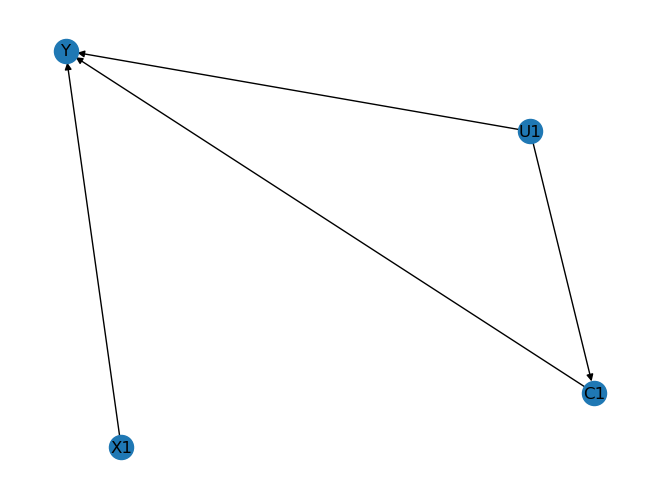

In [51]:
nx.draw(ccg, with_labels=True)

In [52]:
ccg = MPSDAGController.simplify(ccg)

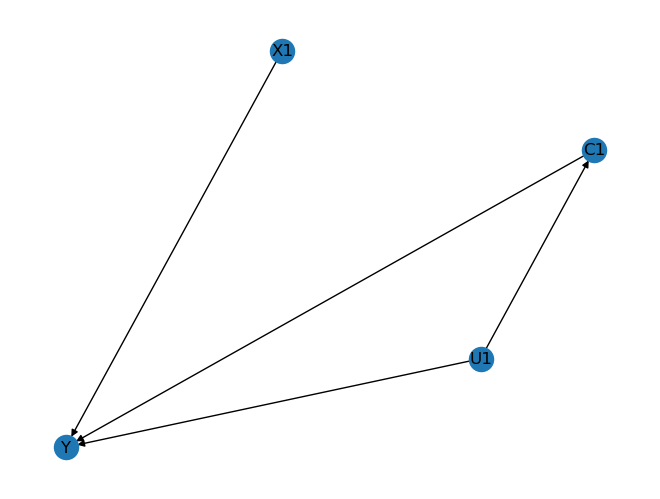

In [53]:
nx.draw(ccg, with_labels=True)

In [54]:
mpses = list(MPSGenerator.mps_for(ccg.interventional_variables, ccg.contextual_variables))
print(len(mpses))
graph_under_mps = [(MPSDAGController.graph_under_mps(mps, ccg), mps) for mps in mpses]
print(len(graph_under_mps))

graph_under_mps = [(g[0][0], g[1]) for g in graph_under_mps if g[0][1]]
print(len(graph_under_mps))

graph_under_mps = [g for g in graph_under_mps if MPSReductor.action_relevance_check(g[1], g[0]) and MPSReductor.context_relevance_check(g[1], g[0])]
print(len(graph_under_mps))
graph_under_mps = [g for g in graph_under_mps if not MPSReductor.sufficiently_not_pomp(g[1], g[0])]
print(len(graph_under_mps))

25
25
8
6
4


In [55]:
graph_under_mps

[(<pomps.contextual_graphs.ContextualCausalGraph at 0x7fc618386bb0>, ),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x7fc5e92318e0>,
  <C1, ['X1']>),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x7fc5e9231cd0>,
  <X1, ['C1']>),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x7fc5e9231070>,
  <C1, []>	<X1, []>)]

NameError: name 'gpf' is not defined

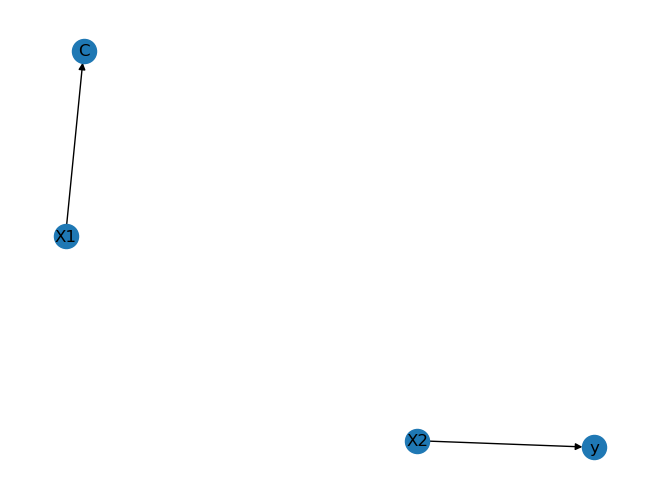

In [10]:
graph, mps = graph_under_mps[-1]
nx.draw(graph, with_labels=True)
is_single_gp = True
if is_single_gp:
    policy = PolicyFCM.mps_to_single_gp(mps, gpf)
else:
    policy = PolicyFCM.mps_to_gp_policy(mps, gpf)
fcm_m = PolicyFCM.fcm_with_policy(fcm, policy)

In [ ]:
# import torch
# torch.set_num_threads(1)

In [11]:
fcm_m.functors

{'aspirin': <pomps.gp_fcm.SharedFunctor at 0x7fd9b860ef70>,
 'cancer': <pomps.fcm.Functor at 0x7fd990ad8160>,
 'statin': <pomps.gp_fcm.SharedFunctor at 0x7fd9b8622100>,
 'age': <pomps.fcm.Functor at 0x7fd990ae7e80>,
 'bmi': <pomps.fcm.Functor at 0x7fd990ae7fd0>,
 'y': <pomps.fcm.Functor at 0x7fd990ad81c0>}

In [8]:
for i in tqdm(range(8)):
    smp = fcm_m.sample(necessary_context=mps.contextual_variables)
    y = smp[graph.target]
    y = torch.tensor([y])
    for p in policy:
        p.functional.observe(-y)
        if is_single_gp:
            break
    print(smp)

  0%|          | 0/8 [00:00<?, ?it/s]

buffer {}
{'age': tensor(59.5990), 'bmi': tensor(26.5162)} {'age': tensor(59.5990), 'bmi': tensor(26.5162)} {'age', 'bmi', 'statin'} {'age', 'bmi'} aspirin
buffer {'statin': False}
{'age': tensor(59.5990), 'bmi': tensor(26.5162), 'aspirin': False, 'statin': False, 'cancer': tensor(0.), 'y': tensor(5.3376)}
buffer {}
{'age': tensor(67.0472), 'bmi': tensor(26.9764)} {'age': tensor(67.0472), 'bmi': tensor(26.9764)} {'age', 'bmi', 'statin'} {'age', 'bmi'} aspirin
buffer {'statin': False}
{'age': tensor(67.0472), 'bmi': tensor(26.9764), 'aspirin': False, 'statin': False, 'cancer': tensor(1.), 'y': tensor(6.6626)}
buffer {}
{'age': tensor(55.8788), 'bmi': tensor(26.4781)} {'age': tensor(55.8788), 'bmi': tensor(26.4781)} {'age', 'bmi', 'statin'} {'age', 'bmi'} aspirin
buffer {'statin': False}
{'age': tensor(55.8788), 'bmi': tensor(26.4781), 'aspirin': True, 'statin': False, 'cancer': tensor(0.), 'y': tensor(6.2371)}
buffer {}
{'age': tensor(69.0651), 'bmi': tensor(26.4519)} {'age': tensor(69.

In [ ]:
%prun -s cumulative fcm_m.sample() 

In [14]:
y_s = []
for i in tqdm(range(80)):
    smp = fcm_m.sample()
    y_s.append(smp['y'])

  0%|          | 0/80 [00:00<?, ?it/s]

In [19]:
torch.tensor(y_s).mean()

tensor(6.1982)

In [6]:
import pandas as pd
pd.DataFrame({'a': [1,2,3], 'b': ['a', 'b', 'c']}).to_dict(orient='records')[0]

{'a': 1, 'b': 'a'}

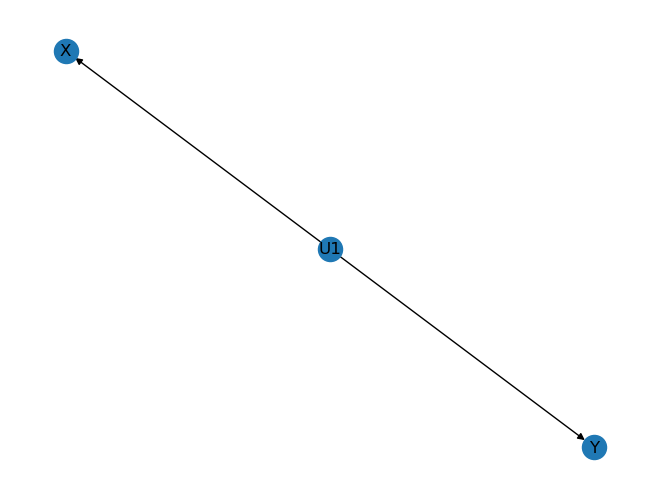

In [12]:
gr = fcm.induced_graph()
gr.contextual_variables = {'Z'}
gr.interventional_variables = {'X'}
sm_gr = MPSDAGController.simplify(gr)
nx.draw(sm_gr, with_labels=True)

In [8]:
sm_gr.contextual_variables, sm_gr.interventional_variables, sm_gr.target, sm_gr.uc_variables

(set(), set(), 'Y', {'U1'})

In [6]:
dr = (nx.DiGraph([('X1', 'X2'), ('C', 'X2'), ('X2', 'Y'), ("U1", "X2"),
                  ("U1", "Y"), ("U2", "X1"), ("U2", "C"), ("C", "Y"), ("U3", "Y")]))
graph = ContextualCausalGraph(edges=dr, uc_variables='auto')
graph.uc_variables

{'U1', 'U2'}

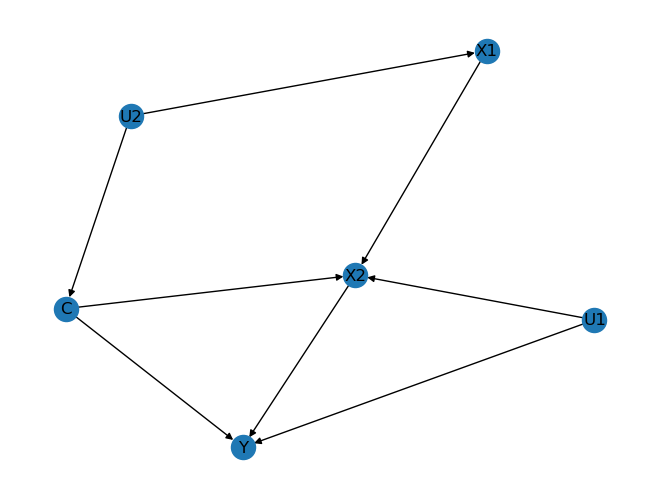

In [9]:
nx.draw(graph, with_labels=True)

In [8]:
mps = MixedPolicyScope([PolicyComponent('X1', {'C'})])
mps_graph, flag = MPSDAGController.graph_under_mps(mps, graph)
assert flag

NetworkXError: The node X1 is not in the digraph.

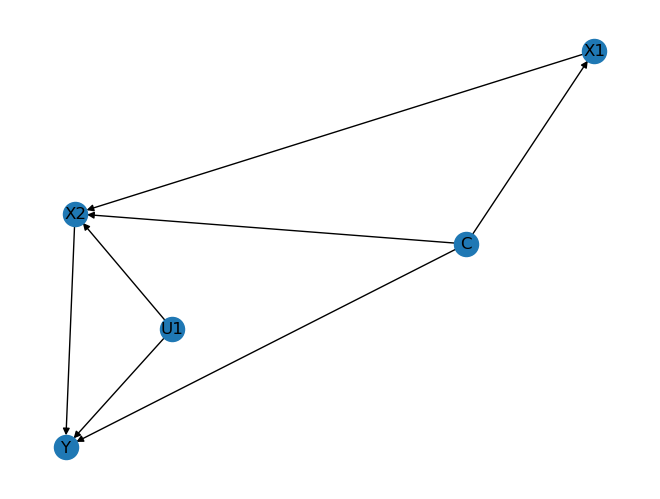

In [5]:
nx.draw(mps_graph, with_labels=True)